In [1]:
import os
import sys
import random
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")

import cv2

from tqdm import tqdm_notebook, tnrange, tqdm
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input, Dropout
from keras.layers.core import Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import backend as K

from scipy import misc, ndimage
from skimage.morphology import reconstruction, disk
from skimage.filters import rank
from skimage import img_as_float, exposure

import tensorflow as tf
from imgaug import augmenters as iaa
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

from sklearn.model_selection import train_test_split

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Set some parameters
im_width = 128
im_height = 128
im_chan = 1
img_size_ori = 101

path_train = '../data/train/'
path_test = '../data/test/'

## Fetch data

In [3]:
train_ids = next(os.walk(path_train+"images"))[2]
test_ids = next(os.walk(path_test+'images'))[2]

In [4]:
def cov_to_class(val):    
    for i in range(0, 11):
        if val * 10 <= i :
            return i

In [55]:
# Get and resize train images and masks
X_train = np.zeros((len(train_ids), im_height, im_width, im_chan), dtype=np.uint8)
coverage = np.zeros((len(train_ids), 2), dtype=np.float32)
Y_train = np.zeros((len(train_ids), im_height, im_width, 1), dtype=np.uint8)

print('Getting and resizing train images and mask ...')
sys.stdout.flush()

for n, id_ in enumerate(tqdm_notebook(train_ids)):
    path = path_train
    img = load_img(path + '/images/' + id_, color_mode = "grayscale")
    x = img_to_array(img)
    x = resize(x, (128, 128, 1), mode='constant', preserve_range=True)
    X_train[n] = x
    
    mask = img_to_array(load_img(path + '/masks/' + id_, color_mode = "grayscale"))
    Y_train[n] = resize(mask, (128, 128, 1), mode='constant', preserve_range=True)
    
    coverage[n, 0] = (mask / 255).sum() / img_size_ori**2
    coverage[n, 1] = cov_to_class(coverage[n, 0])
    
print('Done!')

Getting and resizing train images and mask ...


/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "



Done!


Text(0.5,0,'Coverage class')

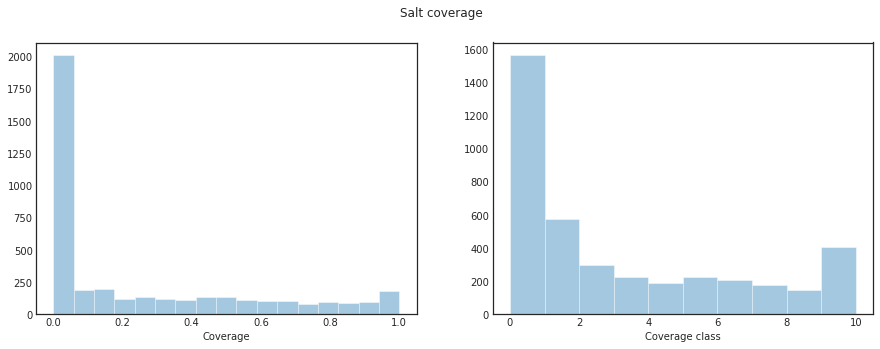

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))
sns.distplot(coverage[:, 0], kde=False, ax=axs[0])
sns.distplot(coverage[:, 1], bins=10, kde=False, ax=axs[1])
plt.suptitle("Salt coverage")
axs[0].set_xlabel("Coverage")
axs[1].set_xlabel("Coverage class")

## Create train/validation split stratified by salt coverage

In [60]:
x_train, x_valid, y_train, y_valid, cov_train, cov_valid = train_test_split(
X_train, Y_train, coverage, test_size=0.1, stratify=coverage[:, 1], random_state=1337)

In [61]:
print('x_train shape', x_train.shape)
print('x_valid shape', x_valid.shape)

x_train shape (3600, 128, 128, 1)
x_valid shape (400, 128, 128, 1)


## View our data

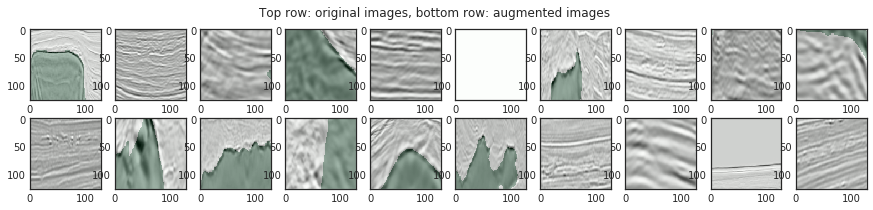

In [10]:
fig, axs = plt.subplots(2, 10, figsize=(15,3))
for i in range(10):
    axs[0][i].imshow(x_train[i].squeeze(), cmap="Greys")
    axs[0][i].imshow(y_train[i].squeeze(), cmap="Greens", alpha=0.3)
    axs[1][i].imshow(x_valid[i].squeeze(), cmap="Greys")
    axs[1][i].imshow(y_valid[i].squeeze(), cmap="Greens", alpha=0.3)

fig.suptitle("Top row: original images, bottom row: augmented images");

## Image deformation

In [11]:
from scipy.ndimage.interpolation import map_coordinates
from scipy.ndimage.filters import gaussian_filter

In [36]:
def elastic_transform(image, alpha, sigma, seed=None):
    """Elastic deformation of images as described in [Simard2003]_.
    .. [Simard2003] Simard, Steinkraus and Platt, "Best Practices for
       Convolutional Neural Networks applied to Visual Document Analysis", in
       Proc. of the International Conference on Document Analysis and
       Recognition, 2003.
    """
    
    if seed is None:
        random_state = np.random.RandomState()
    else:
        random_state = np.random.RandomState(seed=seed)
    
    shape = image.shape
    dx = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha
    dy = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha

    x, y = np.meshgrid(np.arange(shape[0]), np.arange(shape[1]))
    indices = np.reshape(y+dy, (-1, 1)), np.reshape(x+dx, (-1, 1))

    return map_coordinates(image, indices, order=1).reshape(shape)

In [69]:
deformed = elastic_transform(x_valid[1].squeeze(), 20, 4, 20)
mask = elastic_transform(y_valid[1].squeeze(), 20, 4, 20)

In [132]:
x_valid[1].squeeze().unsqueeze().shape

AttributeError: 'numpy.ndarray' object has no attribute 'unsqueeze'

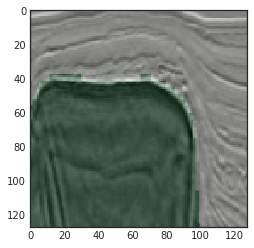

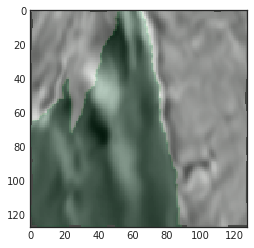

In [70]:
fig, ax = plt.subplots(1, 1)
ax.imshow(x_train[0].squeeze(), cmap='gray')
ax.imshow(y_train[0].squeeze(), cmap="Greens", alpha=0.3)
plt.show()

fig, ax = plt.subplots(1, 1)
ax.imshow(deformed, cmap='gray')
ax.imshow(mask, cmap="Greens", alpha=0.3)

## Invert

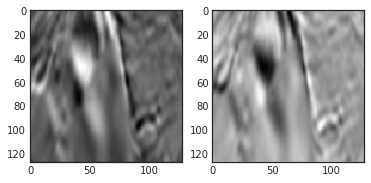

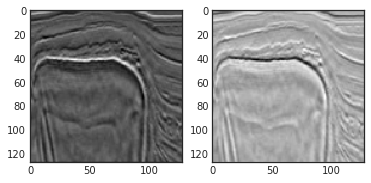

In [135]:
inv = iaa.Invert(p=1)

fig, axs = plt.subplots(1, 2)

axs[0].imshow(x_valid[1].squeeze(), cmap='gray')
axs[1].imshow(inv.augment_image(x_valid[1]).squeeze(), cmap='gray');
plt.show()

fig, axs = plt.subplots(1, 2)

axs[0].imshow(x_train[0].squeeze(), cmap='gray')
axs[1].imshow(inv.augment_image(x_train[0].squeeze()), cmap='gray');

## Add

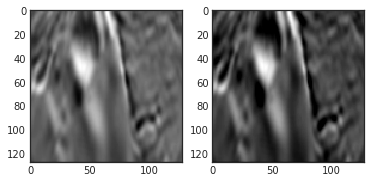

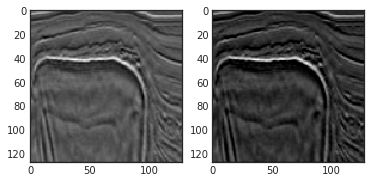

In [87]:
inv = iaa.Add(value=-45)

fig, axs = plt.subplots(1, 2)

axs[0].imshow(x_valid[1].squeeze(), cmap='gray')
axs[1].imshow(inv.augment_image(x_valid[1].squeeze()), cmap='gray');
plt.show()

fig, axs = plt.subplots(1, 2)

axs[0].imshow(x_train[0].squeeze(), cmap='gray')
axs[1].imshow(inv.augment_image(x_train[0].squeeze()), cmap='gray');

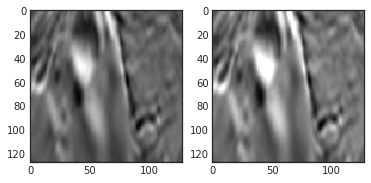

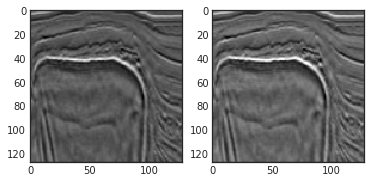

In [88]:
inv = iaa.Add(value=45)

fig, axs = plt.subplots(1, 2)

axs[0].imshow(x_valid[1].squeeze(), cmap='gray')
axs[1].imshow(inv.augment_image(x_valid[1].squeeze()), cmap='gray');
plt.show()

fig, axs = plt.subplots(1, 2)

axs[0].imshow(x_train[0].squeeze(), cmap='gray')
axs[1].imshow(inv.augment_image(x_train[0].squeeze()), cmap='gray');

## Sharpen

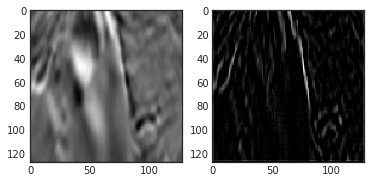

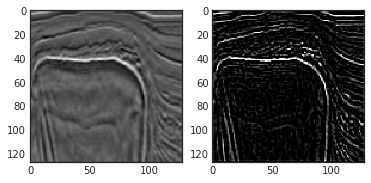

In [89]:
inv = iaa.Sharpen(alpha=1, lightness=0.)

fig, axs = plt.subplots(1, 2)

axs[0].imshow(x_valid[1].squeeze(), cmap='gray')
axs[1].imshow(inv.augment_image(x_valid[1].squeeze()), cmap='gray');
plt.show()

fig, axs = plt.subplots(1, 2)

axs[0].imshow(x_train[0].squeeze(), cmap='gray')
axs[1].imshow(inv.augment_image(x_train[0].squeeze()), cmap='gray');

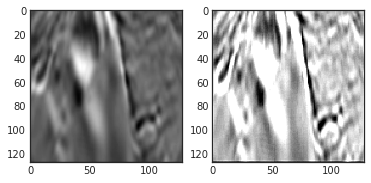

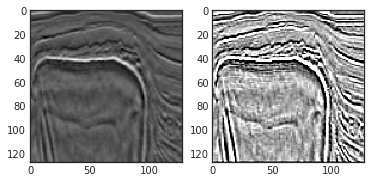

In [90]:
inv = iaa.Sharpen(alpha=1, lightness=2.)

fig, axs = plt.subplots(1, 2)

axs[0].imshow(x_valid[1].squeeze(), cmap='gray')
axs[1].imshow(inv.augment_image(x_valid[1].squeeze()), cmap='gray');
plt.show()

fig, axs = plt.subplots(1, 2)

axs[0].imshow(x_train[0].squeeze(), cmap='gray')
axs[1].imshow(inv.augment_image(x_train[0].squeeze()), cmap='gray');

## Emboss

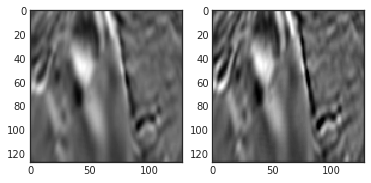

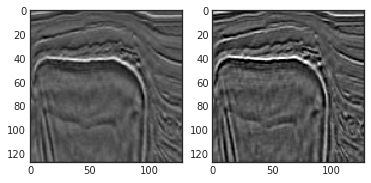

In [92]:
inv = iaa.Emboss(alpha=1, strength=0.)

fig, axs = plt.subplots(1, 2)

axs[0].imshow(x_valid[1].squeeze(), cmap='gray')
axs[1].imshow(inv.augment_image(x_valid[1].squeeze()), cmap='gray');
plt.show()

fig, axs = plt.subplots(1, 2)

axs[0].imshow(x_train[0].squeeze(), cmap='gray')
axs[1].imshow(inv.augment_image(x_train[0].squeeze()), cmap='gray');

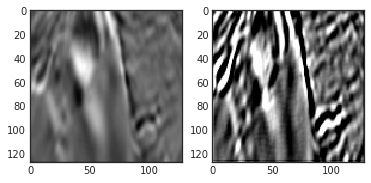

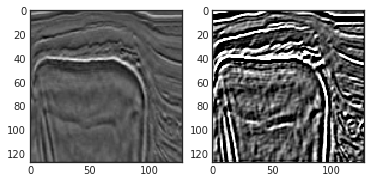

In [93]:
inv = iaa.Emboss(alpha=1, strength=2.)

fig, axs = plt.subplots(1, 2)

axs[0].imshow(x_valid[1].squeeze(), cmap='gray')
axs[1].imshow(inv.augment_image(x_valid[1].squeeze()), cmap='gray');
plt.show()

fig, axs = plt.subplots(1, 2)

axs[0].imshow(x_train[0].squeeze(), cmap='gray')
axs[1].imshow(inv.augment_image(x_train[0].squeeze()), cmap='gray');

## AdditiveGaussianNoise

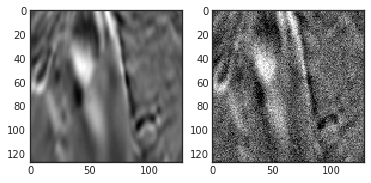

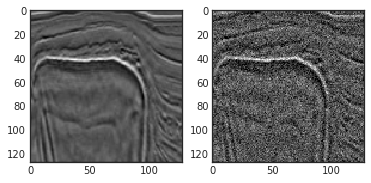

In [98]:
inv = iaa.AdditiveGaussianNoise(scale=0.1*255)

fig, axs = plt.subplots(1, 2)

axs[0].imshow(x_valid[1].squeeze(), cmap='gray')
axs[1].imshow(inv.augment_image(x_valid[1].squeeze()), cmap='gray');
plt.show()

fig, axs = plt.subplots(1, 2)

axs[0].imshow(x_train[0].squeeze(), cmap='gray')
axs[1].imshow(inv.augment_image(x_train[0].squeeze()), cmap='gray');

## CoarseDropout

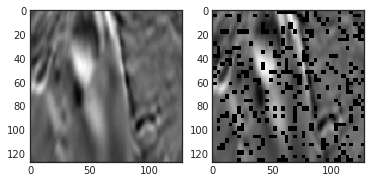

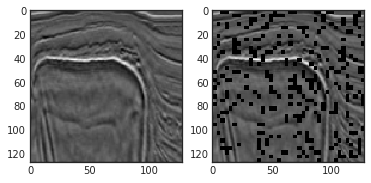

In [99]:
inv = iaa.CoarseDropout(p=0.2, size_percent=0.3)

fig, axs = plt.subplots(1, 2)

axs[0].imshow(x_valid[1].squeeze(), cmap='gray')
axs[1].imshow(inv.augment_image(x_valid[1].squeeze()), cmap='gray');
plt.show()

fig, axs = plt.subplots(1, 2)

axs[0].imshow(x_train[0].squeeze(), cmap='gray')
axs[1].imshow(inv.augment_image(x_train[0].squeeze()), cmap='gray');

## Contrast Normalization

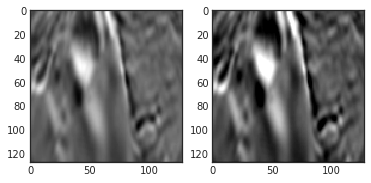

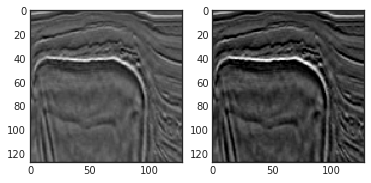

In [100]:
inv = iaa.ContrastNormalization(alpha=1.5)

fig, axs = plt.subplots(1, 2)

axs[0].imshow(x_valid[1].squeeze(), cmap='gray')
axs[1].imshow(inv.augment_image(x_valid[1].squeeze()), cmap='gray');
plt.show()

fig, axs = plt.subplots(1, 2)

axs[0].imshow(x_train[0].squeeze(), cmap='gray')
axs[1].imshow(inv.augment_image(x_train[0].squeeze()), cmap='gray');

## Scale

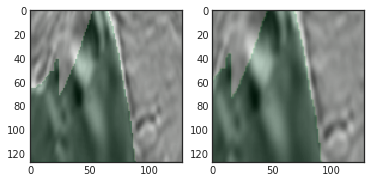

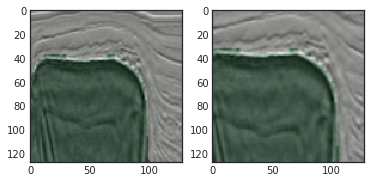

In [137]:
inv = iaa.Affine(scale=1.2)

fig, axs = plt.subplots(1, 2)

axs[0].imshow(x_valid[1].squeeze(), cmap='gray')
axs[0].imshow(y_valid[1].squeeze(), cmap='Greens', alpha=0.3)
axs[1].imshow(inv.augment_image(x_valid[1].squeeze()), cmap='gray');
axs[1].imshow(inv.augment_image(y_valid[1].squeeze()), cmap='Greens', alpha=0.3);
plt.show()

fig, axs = plt.subplots(1, 2)

axs[0].imshow(x_train[0].squeeze(), cmap='gray')
axs[0].imshow(y_train[0].squeeze(), cmap='Greens', alpha=0.3)
axs[1].imshow(inv.augment_image(x_train[0].squeeze()), cmap='gray');
axs[1].imshow(inv.augment_image(y_train[0].squeeze()), cmap='Greens', alpha=0.3);


## Translate

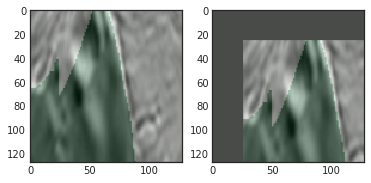

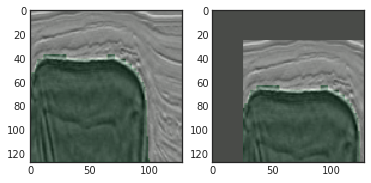

In [140]:
inv = iaa.Affine(translate_percent=0.2)

fig, axs = plt.subplots(1, 2)

axs[0].imshow(x_valid[1].squeeze(), cmap='gray')
axs[0].imshow(y_valid[1].squeeze(), cmap='Greens', alpha=0.3)
axs[1].imshow(inv.augment_image(x_valid[1].squeeze()), cmap='gray');
axs[1].imshow(inv.augment_image(y_valid[1].squeeze()), cmap='Greens', alpha=0.3);
plt.show()

fig, axs = plt.subplots(1, 2)

axs[0].imshow(x_train[0].squeeze(), cmap='gray')
axs[0].imshow(y_train[0].squeeze(), cmap='Greens', alpha=0.3)
axs[1].imshow(inv.augment_image(x_train[0].squeeze()), cmap='gray');
axs[1].imshow(inv.augment_image(y_train[0].squeeze()), cmap='Greens', alpha=0.3);


## Rotate

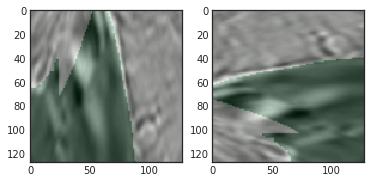

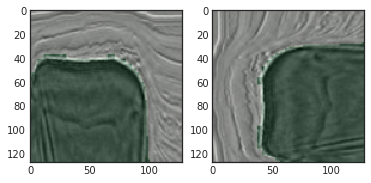

In [121]:
inv = iaa.Affine(rotate=-90)

fig, axs = plt.subplots(1, 2)

axs[0].imshow(x_valid[1].squeeze(), cmap='gray')
axs[0].imshow(y_valid[1].squeeze(), cmap='Greens', alpha=0.3)
axs[1].imshow(inv.augment_image(x_valid[1].squeeze()), cmap='gray');
axs[1].imshow(inv.augment_image(y_valid[1].squeeze()), cmap='Greens', alpha=0.3);
plt.show()

fig, axs = plt.subplots(1, 2)

axs[0].imshow(x_train[0].squeeze(), cmap='gray')
axs[0].imshow(y_train[0].squeeze(), cmap='Greens', alpha=0.3)
axs[1].imshow(inv.augment_image(x_train[0].squeeze()), cmap='gray');
axs[1].imshow(inv.augment_image(y_train[0].squeeze()), cmap='Greens', alpha=0.3);


## Elastic Transformation

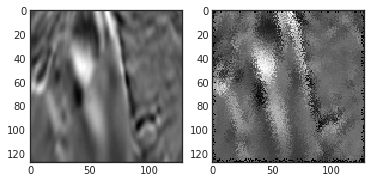

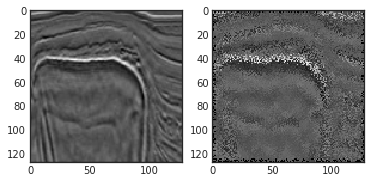

In [130]:
inv = iaa.ElasticTransformation(sigma=0.2, alpha=3.)

fig, axs = plt.subplots(1, 2)

axs[0].imshow(x_valid[1].squeeze(), cmap='gray')
axs[1].imshow(inv.augment_image(x_valid[1].squeeze()), cmap='gray');
plt.show()

fig, axs = plt.subplots(1, 2)

axs[0].imshow(x_train[0].squeeze(), cmap='gray')
axs[1].imshow(inv.augment_image(x_train[0].squeeze()), cmap='gray');